<a href="https://colab.research.google.com/github/JeroenVanB/FruitClassification/blob/main/classify_fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit classification
## Refrences:
- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/tutorials/images/classification
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.kaggle.com/moltean/fruits


###Preprocessing


In [7]:
USING_COLAB = True
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pathlib

In [8]:
if USING_COLAB:
  from google.colab import drive
  drive.mount("/content/gdrive")
  !unzip '/content/gdrive/My Drive/Deep Learning/Dataset.zip'

data_dir = 'Dataset/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/My Drive/Deep Learning/Dataset.zip
replace __MACOSX/._Dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [16]:
train_dir = pathlib.Path(data_dir + 'Train')
BATCH_SIZE = 32
IMG_SIZE = (100,100)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path(data_dir + 'Test'),
    shuffle=True,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)
num_of_classes = len(class_names)


Found 25885 files belonging to 6 classes.
Using 20708 files for training.
Found 25885 files belonging to 6 classes.
Using 5177 files for validation.
Found 8650 files belonging to 6 classes.
['Apples', 'Cherries', 'Grapes', 'Pear', 'Peppers', 'Tomatoes']


###Visualize data

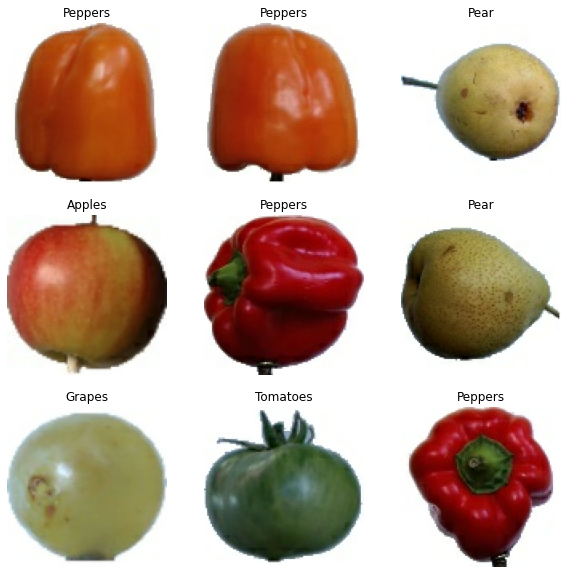

In [10]:
def plot_images():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
plot_images()

###Data performance/caching and augmentation

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 100, 100, 3)
(32,)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Simple Conv Net

In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [15]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
648/648 [==============================] - 22s 24ms/step - loss: 0.5171 - accuracy: 0.8134 - val_loss: 0.0092 - val_accuracy: 0.9983
Epoch 2/3
648/648 [==============================] - 7s 11ms/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 1.7008e-04 - val_accuracy: 1.0000
Epoch 3/3
648/648 [==============================] - 7s 11ms/step - loss: 1.1799e-04 - accuracy: 1.0000 - val_loss: 5.8772e-05 - val_accuracy: 1.0000


In [16]:
model.evaluate(test_ds)

271/271 [==============================] - 6s 21ms/step - loss: 0.0792 - accuracy: 0.9831


[0.07920823991298676, 0.983121395111084]

### MobileNetV2

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

## This feature extractor will convert each 100x100x3 image into a 5x5x1280 block of features
# image_batch, label_batch = next(iter(train_ds))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_of_classes,)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 6)


####Important note about BatchNormalization layers
[TF Source.](https://www.tensorflow.org/tutorials/images/transfer_learning#important_note_about_batchnormalization_layers)
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [19]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


162/162 [==============================] - 2s 9ms/step - loss: 2.3368 - accuracy: 0.2270
initial loss: 2.34
initial accuracy: 0.23
Epoch 1/10
648/648 [==============================] - 14s 18ms/step - loss: 0.9762 - accuracy: 0.6428 - val_loss: 0.3577 - val_accuracy: 0.9028
Epoch 2/10
648/648 [==============================] - 8s 13ms/step - loss: 0.3611 - accuracy: 0.8743 - val_loss: 0.1973 - val_accuracy: 0.9585
Epoch 3/10
648/648 [==============================] - 8s 13ms/step - loss: 0.2342 - accuracy: 0.9224 - val_loss: 0.1388 - val_accuracy: 0.9737
Epoch 4/10
648/648 [==============================] - 8s 13ms/step - loss: 0.1750 - accuracy: 0.9434 - val_loss: 0.1061 - val_accuracy: 0.9803
Epoch 5/10
648/648 [==============================] - 8s 13ms/step - loss: 0.1422 - accuracy: 0.9535 - val_loss: 0.0859 - val_accuracy: 0.9853
Epoch 6/10
648/648 [==============================] - 8s 13ms/step - loss: 0.1115 - accuracy: 0.9656 - val_loss: 0.0714 - val_accuracy: 0.9884
Epoch 7/10

#### Learning curves plot

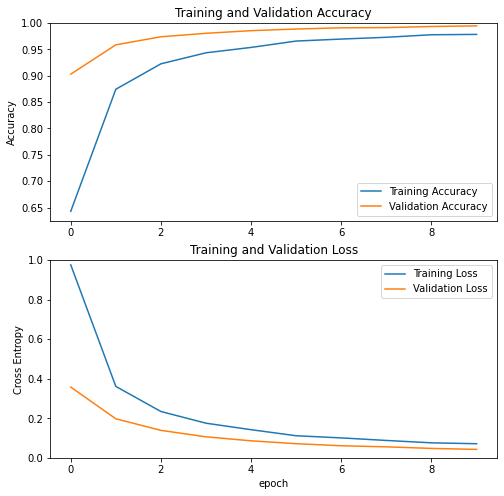

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Important note about difference in validation metrics
If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

[1 1 2 0 0 1 3 0 2 3 0 1 2 4 0 1 0 4 0 1 4 5 4 3 5 2 1 3 3 0 3 5]


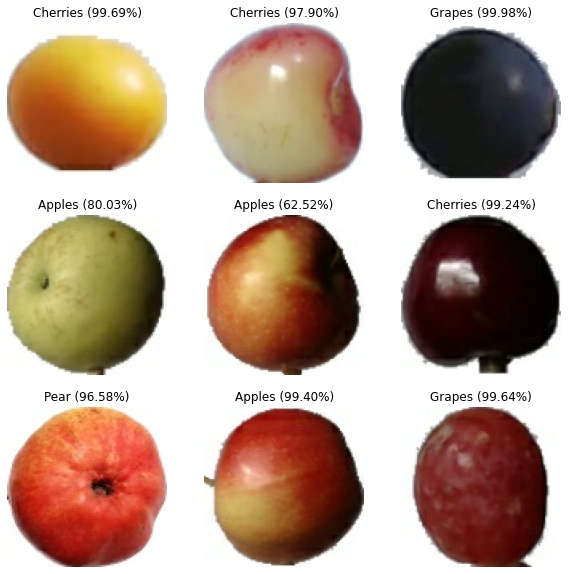

In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
print(label_batch)
predictions = model.predict_on_batch(image_batch)
score = tf.nn.softmax(predictions[0])

# print(label_batch[0])
# print(score)

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

plt.figure(figsize=(10, 10))
for i in range(9):
  score = tf.nn.softmax(predictions[i])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(score)] + ' ({:.2f}%)'.format(100 * np.max(score)))
  plt.axis("off")

